# Logisitic Regression Modeling

In this notebook, we iterate through a logisitic regression baseline, trying different class imbalance remedy methods. We also grid search to try and optomize the baseline's hyperparameters.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()
%matplotlib inline
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
import pickle

## Importing X and y from `nlp_preprocessing.ipynb`

In [17]:
X_lem = pickle.load(open(r'C:\Users\Ricky\Desktop\4.2 FINAL SEMESTER\PROJECT II  Computer systems Project\rOOT\Preprocessing\pickle\X_lem.pkl', 'rb'))
y_lem = pd.read_pickle(r'C:\Users\Ricky\Desktop\4.2 FINAL SEMESTER\PROJECT II  Computer systems Project\rOOT\Preprocessing\pickle\y_lem.pkl')

In [18]:
# setting up stop words
stop_words = set(stopwords.words('english'))

## Train-Test Split & Vectorize

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

# using tf_idf vectorizor
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [20]:
# sparse matrix format with 265K stored elements
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

### Class Imbalance in Training Set 

In [21]:
# creating single df for training set
X_train_df = pd.DataFrame(data=tfidf_data_train, index=None, columns=['tweet']) 
y_train_df = pd.DataFrame(data=y_train, index=None, columns=['label']) 
# joining them
training = pd.concat([X_train_df, y_train_df], axis=1)

In [22]:
training.head(2)

,tweet,label
0,"(0, 176317)\t0.2391880789560643\n (0, 12683...",0.0
1,"(0, 122955)\t0.25362234375833337\n (0, 1178...",0.0


In [23]:
# separate minority and majority classes
hate = training[training.label==1]
not_hate = training[training.label==0]

In [24]:
hate.shape

(2564, 2)

In [25]:
not_hate.shape

(37576, 2)

We can see that this data has a huge **class imbalance**. After running a baseline, we can try oversampling the minority class (hate speech) with SMOTE and undersampling the majority class with Tomek Links.

## Baseline Logistic Regression


In [26]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced')
# class_weight='balanced' actually didn't impact the score



In [27]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(solver='lbfgs', max_iter=300000)

In [28]:
%%time
logreg_baseline.fit(tfidf_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(tfidf_data_test)

Wall time: 10.7 s


c:\Users\Ricky\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
logreg_precision = precision_score(y_test, logreg_test_preds)
logreg_recall = recall_score(y_test, logreg_test_preds)
logreg_f1_score = f1_score(y_test, logreg_test_preds)
logreg_weighted_f1_score = f1_score(y_test, logreg_test_preds, average='weighted')

In [30]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(logreg_precision))
print('Recall: {:.4}'.format(logreg_recall))
print('F1 Score: {:.4}'.format(logreg_f1_score))

Testing Metrics for Logistic Regression Baseline with Lemmatization Features
Precision: 0.2199
Recall: 0.6799
F1 Score: 0.3324


In [55]:
# creating dictionary with all metrics
metric_dict = {}
metric_dict['Baseline Logisitic Regression'] = {'precision': logreg_precision, 'recall': logreg_recall, 'f1_score': logreg_f1_score, 'weighted_f1': logreg_weighted_f1_score}

(2.5, -0.5)

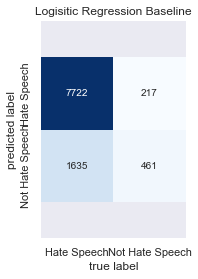

In [17]:
mat = confusion_matrix(y_test, logreg_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Hate Speech', 'Not Hate Speech'], yticklabels=['Hate Speech', 'Not Hate Speech'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Logisitic Regression Baseline')

# fixing matplotlib heatmap cutoff issue
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

## Baseline with SMOTE
Used to over-sample the minority class (hate speech).

In [67]:
import numpy as np
X_train_array = np.asarray(X_train)
X_train_fix = np.reshape(X_train_array, (-1, 1))
X_train_final = np.array(list(X_train_fix)).reshape(-1,1)

In [32]:
y_train_fix = np.reshape(y_train.values, (-1, 1))
y_train_final = np.array(list(y_train_fix)).reshape(-1,1)

In [68]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=35)
smote_X_train, smote_y_train = sm.fit_resample(tfidf_data_train, y_train)

In [51]:
smote_logreg = LogisticRegression(penalty='l2', random_state=35)

In [69]:
%%time
smote_logreg.fit(smote_X_train, smote_y_train)
smote_logreg_test_preds = smote_logreg.predict(tfidf_data_test)

Wall time: 7.92 s


In [53]:
smote_precision = precision_score(y_test, smote_logreg_test_preds)
smote_recall = recall_score(y_test, smote_logreg_test_preds)
smote_f1_score = f1_score(y_test, smote_logreg_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_logreg_test_preds, average='weighted')

In [37]:
# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Oversampled Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(smote_precision))
print('Recall: {:.4}'.format(smote_recall))
print('F1 Score: {:.4}'.format(smote_f1_score))

Testing Metrics for Oversampled Logistic Regression Baseline with Lemmatization Features
Precision: 0.2363
Recall: 0.5796
F1 Score: 0.3358


In [56]:
metric_dict['Baseline Log Reg Oversampled with SMOTE'] = {'precision': smote_precision, 'recall': smote_recall, 'f1_score': smote_f1_score,  'weighted_f1': smote_weighted_f1_score}

## Baseline with Tomek Links
Used to under-sample the majority class (not hate speech).

In [41]:
from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 37466, 1: 2564})


It only removed 48((())) values from the majority class.

In [42]:
tomek_logreg = LogisticRegression(penalty='l2', random_state=55)

In [43]:
%%time
tomek_logreg.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_logreg.predict(tfidf_data_test)

Wall time: 6.42 s


In [44]:
tomek_precision = precision_score(y_test, tomek_logreg_test_preds)
tomek_recall = recall_score(y_test, tomek_logreg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_logreg_test_preds)

In [45]:

# printing evaluation metrics up to 4th decimal place
print('Testing Metrics for Undersampled Logistic Regression Baseline with Lemmatization Features')
print('Precision: {:.4}'.format(tomek_precision))
print('Recall: {:.4}'.format(tomek_recall))
print('F1 Score: {:.4}'.format(tomek_f1_score))

Testing Metrics for Undersampled Logistic Regression Baseline with Lemmatization Features
Precision: 0.3553
Recall: 0.03982
F1 Score: 0.07162


In [57]:
metric_dict['Baseline Log Reg Undersampled with Tomek Links'] = {'precision': tomek_precision, 'recall': tomek_recall, 'f1_score': tomek_f1_score}

### Metrics for All Baselines

In [63]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score,weighted_f1
Baseline Logisitic Regression,0.219943,0.679941,0.332372,0.855050
Baseline Log Reg Oversampled with SMOTE,0.236320,0.579646,0.335754,0.873338
Baseline Log Reg Undersampled with Tomek Links,0.355263,0.039823,0.071618,NaN


Out of all of them, **the baseline oversampled with SMOTE** performed the best. So let's run grid search on that one to find the optimal parameters.

It's important to note that this model produces the same score as a baseline SVM.

## Grid Search without SMOTE

In [67]:
# creating the model
baseline_model = LogisticRegression(class_weight='balanced', random_state=10)

In [68]:
# creating param_dict
param_dict={'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'newton-cg', 'sag'], 'C':
[100, 10, 1.0, 0.1, 0.01]}

In [69]:
# instantiate Grid Search CV with F1 metric
grid_baseline = GridSearchCV(baseline_model, param_dict, cv=5, scoring='f1', verbose=1)

In [72]:
my_str = 'tweet'

my_float = float(my_str.replace(',', '').replace('%', ''))

print(my_float)  # 👉️ 12.345


ValueError: could not convert string to float: 'tweet'

In [ ]:

   #FROM ONLINE TO INCREASE NO. of Iteractions
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(max_iter=3000)
model.fit(X_train,y_train)

In [59]:
model.fit(X_train,y_train)

ValueError: could not convert string to float: 'lying dont worship bab people worship people like raila uhuru known nyakundi list'

In [70]:
%%time
# fit the grid search to our data
grid_baseline.fit(tfidf_data_train, y_train)

# 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\Ricky\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# Predict the response for test dataset
grid_base_y_pred_train = grid_baseline.best_estimator_.predict(tfidf_data_train)

# predict the training set
grid_base_y_pred_test = grid_baseline.best_estimator_.predict(tfidf_data_test)

# Model F1, how often is the classifier correct?
print('Tuned Logistic Regression Model Predictions')
print("F1 on train set:",metrics.f1_score(y_train, grid_base_y_pred_train))
print("F1 on test set:",metrics.f1_score(y_test, grid_base_y_pred_test))